## This file contains the code which defines the Convolutional VAE and performs the training and validation on the MNIST dataset.

---
####  Part 1: Defining necessary functions, preprocessing MNIST dataset and Training loop.

####  Part 2: Plots of the result.

# Part 1: Defining necessary functions, preprocessing MNIST dataset and Training loop.

In [ ]:

import torch 
torch.manual_seed(1) # plant the random torch seed for reproduction
torch.cuda.manual_seed(1) # plant the random cuda seed for reproduction
import imageio
import numpy as np
from tqdm import tqdm
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision.utils import save_image
to_pil_image = transforms.ToPILImage()


def save_reconstructed_images(recon_images, epoch):
    save_image(recon_images.cpu(), f"ConvVAE_Recon_Image" + str(epoch) + ".jpg")

def save_loss_plot(train_loss, valid_loss, model_name):
    plt.figure(figsize=(10, 7))
    plt.plot(train_loss, color='orange', label='train loss')
    plt.plot(valid_loss, color='red', label='validataion loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(f"{model_name}_Loss" + str(epoch) + ".jpg")
    plt.show()


# from tqdm import tqdm
########  The Loss Function  ########

def final_loss(bce_loss, mu, logvar):
    BCE = bce_loss # recontruction loss, mu: the mean from the latent vector; logvar: log variance from the latent vector
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) # KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    return BCE + KLD


######## Define The Training Function ########

def train(model, dataloader, dataset, device, optimizer, criterion):
    model.train()
    # Initial value of the loss function
    running_loss = 0.0
    # Initial value of the reconstruction loss measured by Binary Cross Entropy(BCE)
    running_bce_loss=0.0
    # Initializes value of the counter 
    counter = 0
    for i, data in tqdm(enumerate(dataloader), total=int(len(dataset)/dataloader.batch_size)):
        counter += 1
        data = data[0]
        data = data.to(device)
        optimizer.zero_grad()
        reconstruction, mu, logvar = model(data)
        bce_loss = criterion(reconstruction, data)
        loss = final_loss(bce_loss, mu, logvar)
        loss.backward()
        running_loss += loss.item()
        running_bce_loss += bce_loss.item() 
        optimizer.step()
    # Calculate the average losses
    train_loss = running_loss / counter
    # Calculate the average bce_loss 
    train_bce_loss = running_bce_loss / counter 
    return train_loss, train_bce_loss



######## Define The Validate Function ########

def validate(model, dataloader, dataset, device, criterion):
    model.eval()
    running_loss = 0.0
    # Add a variable to store total bce_loss
    running_bce_loss = 0.0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(dataset)/dataloader.batch_size)):
            counter += 1
            data= data[0]
            data = data.to(device)
            reconstruction, mu, logvar = model(data)
            bce_loss = criterion(reconstruction, data)
            loss = final_loss(bce_loss, mu, logvar)
            running_loss += loss.item()
            running_bce_loss += bce_loss.item() # newly added
            # save the last batch input and output of every epoch
            if i == int(len(dataset)/dataloader.batch_size) - 1:
                recon_images = reconstruction
    val_loss = running_loss / counter
    # Calculate the average bce_loss
    val_bce_loss = running_bce_loss / counter
    return val_loss, val_bce_loss, recon_images



######## Preparation of the Convolutional Variational Autoencoder Model ########

import torch
import torch.nn as nn
import torch.nn.functional as F

# Initial paramters setting
kernel_size = 4 # (4, 4) kernel
init_channels = 8 # initial number of filters
image_channels = 1 # MNIST images are grayscale
latent_dim = 16 # latent dimension for sampling

######## Defining the Convolutional Variational Autoencoder Class ########

class ConvVAE(nn.Module):
    def __init__(self, latent_dim=16):
        super(ConvVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(32 * 7 * 7, latent_dim)
        self.fc_logvar = nn.Linear(32 * 7 * 7, latent_dim)
        self.fc_decode = nn.Linear(latent_dim, 32 * 7 * 7)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.shape[0], -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def decode(self, z):
        z = self.fc_decode(z)
        z = z.view(z.shape[0], 32, 7, 7)
        x = self.decoder(z)
        return x

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar

 
   

########  Training Convolutional Variational Autoencoder on MNIST Dataset ######## 

import torch
import torch.optim as optim
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision
import matplotlib
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
matplotlib.style.use('ggplot')


#### Setting the Computation Device and Learning Parameters ###
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Initialize the model
model = ConvVAE().to(device)
# Set parameters
lr = 0.001
epochs = 101
batch_size = 128
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss(reduction='sum')
# A list to save all the reconstructed images in PyTorch grid format
grid_images = []


######## Prepare the Dataset ######## 

transform = transforms.Compose([
    transforms.ToTensor(),
])
# Training set and train data loader
trainset = torchvision.datasets.MNIST(
    root='../input', train=True, download=True, transform=transform
)
trainloader = DataLoader(
    trainset, batch_size=batch_size, shuffle=True
)
# Validation set and validation data loader
validationset = torchvision.datasets.MNIST(
    root='../input', train=False, download=True, transform=transform
)
validationloader = DataLoader(
    validationset, batch_size=batch_size, shuffle=False
)



########  The train loop ######## 

train_epoch_losses = []
val_epoch_losses = []
train_epoch_bce_losses = []
val_epoch_bce_losses = []

for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss,train_epoch_bce_loss = train(
        model, trainloader, trainset, device, optimizer, criterion
    )
    valid_epoch_loss, val_epoch_bce_loss, recon_images = validate(
        model, validationloader, validationset, device, criterion
    )
    train_epoch_losses.append(train_epoch_loss)
    train_epoch_bce_losses.append(train_epoch_bce_loss)
    val_epoch_losses.append(valid_epoch_loss)
    val_epoch_bce_losses.append(val_epoch_bce_loss)
    # Save the reconstructed images from the validation loop
    save_reconstructed_images(recon_images, epoch+1)
    # Convert the reconstructed images to PyTorch image grid format
    image_grid = make_grid(recon_images.detach().cpu())
    grid_images.append(image_grid)
    # Print the losses
    print(f"Train Loss: {train_epoch_losses[-1]:.4f} | Train BCE Loss: {train_epoch_bce_losses[-1]:.4f}")
    print(f"Val Loss: {val_epoch_losses[-1]:.4f} | Validation BCE Loss: {val_epoch_bce_losses[-1]:.4f}")


100%|██████████| 9912422/9912422 [00:00<00:00, 58599432.33it/s]


Extracting ../input/MNIST/raw/train-images-idx3-ubyte.gz to ../input/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 72710500.49it/s]

Extracting ../input/MNIST/raw/train-labels-idx1-ubyte.gz to ../input/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 26756002.00it/s]


Extracting ../input/MNIST/raw/t10k-images-idx3-ubyte.gz to ../input/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 15203933.57it/s]

Extracting ../input/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../input/MNIST/raw



Epoch 1 of 101


469it [00:59,  7.89it/s]
79it [00:03, 23.21it/s]                        


Train Loss: 22532.5089 | Train BCE Loss: 19913.1429
Val Loss: 16444.2992 | Validation BCE Loss: 13451.2838
Epoch 2 of 101


469it [00:32, 14.51it/s]                         
79it [00:03, 24.72it/s]                        


Train Loss: 16276.6713 | Train BCE Loss: 13244.9379
Val Loss: 15602.5007 | Validation BCE Loss: 12606.1428
Epoch 3 of 101


469it [00:34, 13.76it/s]                         
79it [00:03, 23.54it/s]                        


Train Loss: 15581.7475 | Train BCE Loss: 12515.0245
Val Loss: 15016.6671 | Validation BCE Loss: 11894.1426
Epoch 4 of 101


469it [00:31, 14.98it/s]
79it [00:04, 18.68it/s]                        


Train Loss: 15071.0983 | Train BCE Loss: 11976.4908
Val Loss: 14581.2846 | Validation BCE Loss: 11471.3100
Epoch 5 of 101


469it [00:32, 14.55it/s]                         
79it [00:03, 21.42it/s]                        


Train Loss: 14737.7516 | Train BCE Loss: 11635.9038
Val Loss: 14342.2335 | Validation BCE Loss: 11301.4960
Epoch 6 of 101


469it [00:33, 14.14it/s]
79it [00:03, 22.34it/s]                        


Train Loss: 14493.2545 | Train BCE Loss: 11401.4211
Val Loss: 14129.0666 | Validation BCE Loss: 11074.6871
Epoch 7 of 101


469it [00:34, 13.68it/s]
79it [00:03, 22.90it/s]                        


Train Loss: 14302.4394 | Train BCE Loss: 11218.6187
Val Loss: 13978.2088 | Validation BCE Loss: 10871.3452
Epoch 8 of 101


469it [00:34, 13.62it/s]                         
79it [00:03, 20.69it/s]                        


Train Loss: 14164.8081 | Train BCE Loss: 11087.8623
Val Loss: 13832.3684 | Validation BCE Loss: 10753.2405
Epoch 9 of 101


469it [00:33, 14.21it/s]
79it [00:03, 20.07it/s]                        


Train Loss: 14056.1474 | Train BCE Loss: 10979.8502
Val Loss: 13747.1804 | Validation BCE Loss: 10793.5154
Epoch 10 of 101


469it [00:34, 13.56it/s]
79it [00:03, 20.72it/s]


Train Loss: 13963.2171 | Train BCE Loss: 10894.6424
Val Loss: 13688.5398 | Validation BCE Loss: 10691.9714
Epoch 11 of 101


469it [00:36, 12.85it/s]                         
79it [00:03, 20.23it/s]


Train Loss: 13899.7242 | Train BCE Loss: 10826.0286
Val Loss: 13621.2859 | Validation BCE Loss: 10622.8756
Epoch 12 of 101


469it [00:33, 14.19it/s]                         
79it [00:03, 20.23it/s]                        


Train Loss: 13838.4790 | Train BCE Loss: 10768.5202
Val Loss: 13561.7799 | Validation BCE Loss: 10549.3506
Epoch 13 of 101


469it [00:32, 14.23it/s]
79it [00:04, 18.88it/s]


Train Loss: 13787.2672 | Train BCE Loss: 10715.5582
Val Loss: 13546.3248 | Validation BCE Loss: 10489.8660
Epoch 14 of 101


469it [00:32, 14.24it/s]
79it [00:04, 16.73it/s]                        


Train Loss: 13740.6705 | Train BCE Loss: 10668.8641
Val Loss: 13464.3420 | Validation BCE Loss: 10496.3598
Epoch 15 of 101


469it [00:31, 14.72it/s]                         
79it [00:04, 16.20it/s]                        


Train Loss: 13694.0758 | Train BCE Loss: 10625.8477
Val Loss: 13445.1869 | Validation BCE Loss: 10468.0342
Epoch 16 of 101


469it [00:32, 14.61it/s]                         
79it [00:04, 18.12it/s]                        


Train Loss: 13658.0739 | Train BCE Loss: 10588.2421
Val Loss: 13435.0795 | Validation BCE Loss: 10452.1294
Epoch 17 of 101


469it [00:33, 13.99it/s]                         
79it [00:04, 19.29it/s]                        


Train Loss: 13632.5013 | Train BCE Loss: 10558.1095
Val Loss: 13368.1090 | Validation BCE Loss: 10333.8723
Epoch 18 of 101


469it [00:32, 14.40it/s]
79it [00:03, 20.79it/s]                        


Train Loss: 13596.5579 | Train BCE Loss: 10522.7437
Val Loss: 13370.4325 | Validation BCE Loss: 10358.3108
Epoch 19 of 101


469it [00:34, 13.71it/s]                         
79it [00:04, 19.74it/s]                        


Train Loss: 13576.5977 | Train BCE Loss: 10501.2792
Val Loss: 13326.6959 | Validation BCE Loss: 10305.3760
Epoch 20 of 101


469it [00:33, 14.05it/s]                         
79it [00:03, 20.57it/s]                        


Train Loss: 13548.9323 | Train BCE Loss: 10477.3886
Val Loss: 13313.5361 | Validation BCE Loss: 10331.1663
Epoch 21 of 101


469it [00:33, 13.90it/s]                         
79it [00:03, 20.14it/s]                        


Train Loss: 13525.3789 | Train BCE Loss: 10454.6221
Val Loss: 13275.4882 | Validation BCE Loss: 10200.7393
Epoch 22 of 101


469it [00:32, 14.27it/s]                         
79it [00:03, 20.55it/s]                        


Train Loss: 13501.8621 | Train BCE Loss: 10431.2116
Val Loss: 13265.8045 | Validation BCE Loss: 10212.5598
Epoch 23 of 101


469it [00:32, 14.57it/s]                         
79it [00:04, 16.82it/s]                        


Train Loss: 13483.9348 | Train BCE Loss: 10411.5511
Val Loss: 13239.1815 | Validation BCE Loss: 10211.2895
Epoch 24 of 101


469it [00:31, 14.68it/s]                         
79it [00:05, 14.91it/s]                        


Train Loss: 13463.1496 | Train BCE Loss: 10389.8543
Val Loss: 13205.5707 | Validation BCE Loss: 10179.2081
Epoch 25 of 101


469it [00:32, 14.24it/s]
79it [00:03, 20.56it/s]                        


Train Loss: 13448.6935 | Train BCE Loss: 10377.5770
Val Loss: 13208.1654 | Validation BCE Loss: 10158.3970
Epoch 26 of 101


469it [00:33, 14.05it/s]
79it [00:03, 21.51it/s]                        


Train Loss: 13427.6622 | Train BCE Loss: 10357.8140
Val Loss: 13192.6830 | Validation BCE Loss: 10196.9295
Epoch 27 of 101


469it [00:36, 12.85it/s]
79it [00:03, 20.99it/s]                        


Train Loss: 13409.2465 | Train BCE Loss: 10340.1314
Val Loss: 13186.1454 | Validation BCE Loss: 10146.3290
Epoch 28 of 101


469it [00:34, 13.69it/s]
79it [00:03, 20.41it/s]                        


Train Loss: 13392.5988 | Train BCE Loss: 10328.3314
Val Loss: 13190.5806 | Validation BCE Loss: 10212.4647
Epoch 29 of 101


469it [00:33, 14.19it/s]                         
79it [00:03, 23.97it/s]                        


Train Loss: 13380.3162 | Train BCE Loss: 10314.0740
Val Loss: 13149.5097 | Validation BCE Loss: 10092.5579
Epoch 30 of 101


469it [00:33, 14.17it/s]                         
79it [00:04, 19.70it/s]                        


Train Loss: 13368.6254 | Train BCE Loss: 10302.7059
Val Loss: 13159.3059 | Validation BCE Loss: 10143.5339
Epoch 31 of 101


469it [00:33, 14.20it/s]
79it [00:05, 15.54it/s]


Train Loss: 13357.6716 | Train BCE Loss: 10292.5697
Val Loss: 13123.0164 | Validation BCE Loss: 10091.6056
Epoch 32 of 101


469it [00:32, 14.40it/s]                         
79it [00:04, 16.17it/s]                        


Train Loss: 13341.6946 | Train BCE Loss: 10278.0289
Val Loss: 13131.4908 | Validation BCE Loss: 10179.6648
Epoch 33 of 101


469it [00:33, 14.12it/s]
79it [00:04, 16.27it/s]                        


Train Loss: 13333.2667 | Train BCE Loss: 10270.9097
Val Loss: 13101.6744 | Validation BCE Loss: 10144.3820
Epoch 34 of 101


469it [00:32, 14.30it/s]                         
79it [00:04, 17.26it/s]                        


Train Loss: 13320.5028 | Train BCE Loss: 10259.0982
Val Loss: 13103.7439 | Validation BCE Loss: 10089.3038
Epoch 35 of 101


469it [00:34, 13.65it/s]                         
79it [00:04, 19.67it/s]                        


Train Loss: 13313.1335 | Train BCE Loss: 10251.9938
Val Loss: 13089.1895 | Validation BCE Loss: 10088.7190
Epoch 36 of 101


469it [00:34, 13.78it/s]
79it [00:03, 20.04it/s]                        


Train Loss: 13300.6902 | Train BCE Loss: 10241.9092
Val Loss: 13086.1815 | Validation BCE Loss: 10054.5858
Epoch 37 of 101


469it [00:34, 13.72it/s]
79it [00:03, 20.16it/s]                        


Train Loss: 13287.2436 | Train BCE Loss: 10228.7075
Val Loss: 13093.0427 | Validation BCE Loss: 10087.6423
Epoch 38 of 101


469it [00:35, 13.38it/s]                         
79it [00:03, 20.11it/s]                        


Train Loss: 13280.3964 | Train BCE Loss: 10220.6531
Val Loss: 13066.1682 | Validation BCE Loss: 10021.1556
Epoch 39 of 101


469it [00:34, 13.59it/s]
79it [00:03, 19.87it/s]                        


Train Loss: 13269.1730 | Train BCE Loss: 10211.0270
Val Loss: 13073.3500 | Validation BCE Loss: 10076.3339
Epoch 40 of 101


469it [00:34, 13.48it/s]                         
79it [00:04, 19.41it/s]                        


Train Loss: 13263.4854 | Train BCE Loss: 10205.5938
Val Loss: 13062.4333 | Validation BCE Loss: 10037.6242
Epoch 41 of 101


469it [00:34, 13.49it/s]
79it [00:04, 19.63it/s]                        


Train Loss: 13259.9039 | Train BCE Loss: 10199.7901
Val Loss: 13031.7898 | Validation BCE Loss: 9972.6244
Epoch 42 of 101


469it [00:35, 13.30it/s]                         
79it [00:03, 20.56it/s]


Train Loss: 13255.6120 | Train BCE Loss: 10193.8630
Val Loss: 13048.5028 | Validation BCE Loss: 10030.0337
Epoch 43 of 101


469it [00:33, 13.86it/s]                         
79it [00:03, 21.43it/s]                        


Train Loss: 13241.7108 | Train BCE Loss: 10183.3569
Val Loss: 13016.8810 | Validation BCE Loss: 10007.4328
Epoch 44 of 101


469it [00:33, 13.95it/s]                         
79it [00:03, 20.19it/s]                        


Train Loss: 13233.7717 | Train BCE Loss: 10177.2600
Val Loss: 13017.0389 | Validation BCE Loss: 10054.4547
Epoch 45 of 101


469it [00:34, 13.43it/s]
79it [00:03, 20.54it/s]                        


Train Loss: 13227.0588 | Train BCE Loss: 10170.8979
Val Loss: 13045.7403 | Validation BCE Loss: 10041.2069
Epoch 46 of 101


469it [00:33, 13.95it/s]                         
79it [00:04, 18.86it/s]


Train Loss: 13220.2028 | Train BCE Loss: 10164.4408
Val Loss: 13005.7013 | Validation BCE Loss: 10057.6047
Epoch 47 of 101


469it [00:33, 14.13it/s]                         
79it [00:04, 17.34it/s]                        


Train Loss: 13212.2580 | Train BCE Loss: 10158.0507
Val Loss: 12994.8069 | Validation BCE Loss: 10054.6954
Epoch 48 of 101


469it [00:34, 13.45it/s]
79it [00:04, 19.20it/s]                        


Train Loss: 13207.5410 | Train BCE Loss: 10153.4288
Val Loss: 13006.4398 | Validation BCE Loss: 10039.8345
Epoch 49 of 101


469it [00:33, 14.08it/s]
79it [00:04, 16.85it/s]                        


Train Loss: 13204.5209 | Train BCE Loss: 10146.8254
Val Loss: 12993.1001 | Validation BCE Loss: 9944.9015
Epoch 50 of 101


469it [00:33, 14.06it/s]                         
79it [00:04, 16.74it/s]


Train Loss: 13198.2094 | Train BCE Loss: 10143.6476
Val Loss: 12999.7163 | Validation BCE Loss: 10008.5220
Epoch 51 of 101


469it [00:33, 14.17it/s]                         
79it [00:04, 15.82it/s]                        


Train Loss: 13190.3995 | Train BCE Loss: 10133.0708
Val Loss: 12997.9761 | Validation BCE Loss: 9981.5572
Epoch 52 of 101


469it [00:34, 13.70it/s]
79it [00:04, 16.77it/s]


Train Loss: 13182.4840 | Train BCE Loss: 10127.2201
Val Loss: 12958.3601 | Validation BCE Loss: 9958.0495
Epoch 53 of 101


469it [00:33, 13.98it/s]
79it [00:04, 16.71it/s]                        


Train Loss: 13177.9077 | Train BCE Loss: 10124.6285
Val Loss: 12972.4229 | Validation BCE Loss: 9878.8588
Epoch 54 of 101


469it [00:33, 14.11it/s]
79it [00:04, 16.36it/s]                        


Train Loss: 13172.5534 | Train BCE Loss: 10120.0898
Val Loss: 12955.2962 | Validation BCE Loss: 9931.1359
Epoch 55 of 101


469it [00:34, 13.78it/s]                         
79it [00:04, 16.16it/s]                        


Train Loss: 13171.8235 | Train BCE Loss: 10116.6166
Val Loss: 12957.8564 | Validation BCE Loss: 9951.6041
Epoch 56 of 101


469it [00:33, 13.84it/s]
79it [00:04, 16.10it/s]                        


Train Loss: 13167.8136 | Train BCE Loss: 10113.1866
Val Loss: 12949.7021 | Validation BCE Loss: 9985.4849
Epoch 57 of 101


469it [00:33, 14.16it/s]                         
79it [00:04, 15.87it/s]


Train Loss: 13163.7057 | Train BCE Loss: 10108.2263
Val Loss: 12969.2828 | Validation BCE Loss: 9971.3724
Epoch 58 of 101


469it [00:34, 13.42it/s]
79it [00:04, 16.99it/s]                        


Train Loss: 13155.1995 | Train BCE Loss: 10100.5267
Val Loss: 12949.3541 | Validation BCE Loss: 9935.6857
Epoch 59 of 101


469it [00:34, 13.77it/s]
79it [00:04, 16.28it/s]                        


Train Loss: 13150.8274 | Train BCE Loss: 10098.7222
Val Loss: 12945.1148 | Validation BCE Loss: 9939.1347
Epoch 60 of 101


469it [00:34, 13.71it/s]                         
79it [00:04, 17.79it/s]                        


Train Loss: 13147.5439 | Train BCE Loss: 10092.9894
Val Loss: 12941.5215 | Validation BCE Loss: 9918.5234
Epoch 61 of 101


469it [00:33, 14.08it/s]
79it [00:04, 17.40it/s]


Train Loss: 13142.5175 | Train BCE Loss: 10088.6824
Val Loss: 12946.9686 | Validation BCE Loss: 9979.1273
Epoch 62 of 101


469it [00:34, 13.65it/s]                         
79it [00:04, 17.52it/s]                        


Train Loss: 13141.3072 | Train BCE Loss: 10088.6418
Val Loss: 12935.8384 | Validation BCE Loss: 9940.0041
Epoch 63 of 101


469it [00:33, 14.04it/s]                         
79it [00:04, 17.02it/s]                        


Train Loss: 13138.1883 | Train BCE Loss: 10081.2126
Val Loss: 12924.1009 | Validation BCE Loss: 9892.0292
Epoch 64 of 101


469it [00:33, 14.11it/s]
79it [00:04, 15.88it/s]                        


Train Loss: 13131.7362 | Train BCE Loss: 10078.1987
Val Loss: 12928.7818 | Validation BCE Loss: 9971.1765
Epoch 65 of 101


469it [00:33, 13.96it/s]                         
79it [00:04, 16.45it/s]                        


Train Loss: 13123.1260 | Train BCE Loss: 10072.6493
Val Loss: 12925.0821 | Validation BCE Loss: 9957.2434
Epoch 66 of 101


469it [00:32, 14.45it/s]                         
79it [00:04, 15.98it/s]                        


Train Loss: 13125.6107 | Train BCE Loss: 10070.9606
Val Loss: 12912.0900 | Validation BCE Loss: 9899.5897
Epoch 67 of 101


469it [00:32, 14.40it/s]                         
79it [00:04, 18.39it/s]                        


Train Loss: 13119.2078 | Train BCE Loss: 10067.8512
Val Loss: 12935.2330 | Validation BCE Loss: 9980.4858
Epoch 68 of 101


469it [00:33, 13.87it/s]                         
79it [00:03, 21.61it/s]                        


Train Loss: 13121.6644 | Train BCE Loss: 10066.6779
Val Loss: 12914.6394 | Validation BCE Loss: 9914.1012
Epoch 69 of 101


469it [00:33, 14.07it/s]                         
79it [00:03, 21.37it/s]                        


Train Loss: 13115.2916 | Train BCE Loss: 10062.7282
Val Loss: 12938.9872 | Validation BCE Loss: 9924.0250
Epoch 70 of 101


469it [00:33, 13.93it/s]
79it [00:03, 21.21it/s]                        


Train Loss: 13112.0452 | Train BCE Loss: 10058.3668
Val Loss: 12901.2173 | Validation BCE Loss: 9866.1287
Epoch 71 of 101


469it [00:33, 13.98it/s]                         
79it [00:03, 22.32it/s]                        


Train Loss: 13104.1986 | Train BCE Loss: 10055.4203
Val Loss: 12932.6215 | Validation BCE Loss: 9950.8130
Epoch 72 of 101


469it [00:34, 13.51it/s]                         
79it [00:03, 21.02it/s]                        


Train Loss: 13109.7425 | Train BCE Loss: 10054.6335
Val Loss: 12902.8298 | Validation BCE Loss: 9929.6783
Epoch 73 of 101


469it [00:33, 13.82it/s]
79it [00:03, 21.42it/s]                        


Train Loss: 13104.1252 | Train BCE Loss: 10049.2590
Val Loss: 12904.3471 | Validation BCE Loss: 9898.6871
Epoch 74 of 101


469it [00:33, 13.85it/s]
79it [00:03, 20.81it/s]


Train Loss: 13101.6613 | Train BCE Loss: 10048.7747
Val Loss: 12899.7364 | Validation BCE Loss: 9933.0074
Epoch 75 of 101


469it [00:35, 13.33it/s]
79it [00:03, 20.66it/s]                        


Train Loss: 13101.2594 | Train BCE Loss: 10047.0926
Val Loss: 12899.1050 | Validation BCE Loss: 9837.4501
Epoch 76 of 101


469it [00:34, 13.77it/s]
79it [00:03, 20.12it/s]                        


Train Loss: 13093.9563 | Train BCE Loss: 10041.6755
Val Loss: 12902.0688 | Validation BCE Loss: 9894.9108
Epoch 77 of 101


469it [00:33, 13.83it/s]                         
79it [00:04, 18.80it/s]                        


Train Loss: 13093.8861 | Train BCE Loss: 10041.5825
Val Loss: 12894.7032 | Validation BCE Loss: 9878.5581
Epoch 78 of 101


469it [00:33, 13.89it/s]
79it [00:05, 15.02it/s]                        


Train Loss: 13090.9673 | Train BCE Loss: 10040.3859
Val Loss: 12906.1537 | Validation BCE Loss: 9934.1087
Epoch 79 of 101


469it [00:33, 14.19it/s]                         
79it [00:04, 16.16it/s]                        


Train Loss: 13090.2060 | Train BCE Loss: 10034.9974
Val Loss: 12882.2872 | Validation BCE Loss: 9885.9860
Epoch 80 of 101


469it [00:33, 14.14it/s]
79it [00:04, 16.42it/s]                        


Train Loss: 13092.7536 | Train BCE Loss: 10034.1343
Val Loss: 12905.6735 | Validation BCE Loss: 9868.6835
Epoch 81 of 101


469it [00:33, 14.21it/s]                         
79it [00:04, 16.50it/s]                        


Train Loss: 13080.6270 | Train BCE Loss: 10028.8317
Val Loss: 12878.1278 | Validation BCE Loss: 9868.9026
Epoch 82 of 101


469it [00:34, 13.76it/s]                         
79it [00:04, 16.56it/s]                        


Train Loss: 13083.8670 | Train BCE Loss: 10031.6643
Val Loss: 12885.2831 | Validation BCE Loss: 9849.4455
Epoch 83 of 101


469it [00:33, 14.11it/s]                         
79it [00:04, 16.54it/s]                        


Train Loss: 13077.2856 | Train BCE Loss: 10025.3455
Val Loss: 12874.3552 | Validation BCE Loss: 9935.4699
Epoch 84 of 101


469it [00:32, 14.23it/s]                         
79it [00:04, 16.63it/s]


Train Loss: 13079.5590 | Train BCE Loss: 10026.5427
Val Loss: 12887.6463 | Validation BCE Loss: 9861.8278
Epoch 85 of 101


469it [00:33, 13.85it/s]                         
79it [00:04, 16.04it/s]                        


Train Loss: 13071.9500 | Train BCE Loss: 10020.0800
Val Loss: 12897.8744 | Validation BCE Loss: 9815.5106
Epoch 86 of 101


469it [00:33, 14.00it/s]
79it [00:04, 16.49it/s]                        


Train Loss: 13074.0676 | Train BCE Loss: 10018.6111
Val Loss: 12868.4665 | Validation BCE Loss: 9862.2534
Epoch 87 of 101


469it [00:32, 14.26it/s]                         
79it [00:04, 17.58it/s]                        


Train Loss: 13070.4130 | Train BCE Loss: 10018.1036
Val Loss: 12865.7985 | Validation BCE Loss: 9913.2473
Epoch 88 of 101


469it [00:34, 13.65it/s]
79it [00:03, 19.80it/s]                        


Train Loss: 13070.1614 | Train BCE Loss: 10017.4551
Val Loss: 12882.0509 | Validation BCE Loss: 9821.9661
Epoch 89 of 101


469it [00:33, 13.89it/s]                         
79it [00:03, 23.54it/s]                        


Train Loss: 13068.2027 | Train BCE Loss: 10014.6581
Val Loss: 12857.7515 | Validation BCE Loss: 9837.5945
Epoch 90 of 101


469it [00:33, 13.81it/s]
79it [00:03, 22.06it/s]                        


Train Loss: 13062.9843 | Train BCE Loss: 10010.8488
Val Loss: 12858.9165 | Validation BCE Loss: 9851.9606
Epoch 91 of 101


469it [00:33, 13.86it/s]                         
79it [00:03, 22.31it/s]                        


Train Loss: 13064.7413 | Train BCE Loss: 10011.6767
Val Loss: 12870.2506 | Validation BCE Loss: 9879.5190
Epoch 92 of 101


469it [00:34, 13.56it/s]
79it [00:03, 21.26it/s]                        


Train Loss: 13064.8761 | Train BCE Loss: 10012.9727
Val Loss: 12878.6515 | Validation BCE Loss: 9887.4935
Epoch 93 of 101


469it [00:34, 13.79it/s]                         
79it [00:03, 21.95it/s]                        


Train Loss: 13063.0549 | Train BCE Loss: 10008.6369
Val Loss: 12863.3090 | Validation BCE Loss: 9866.8752
Epoch 94 of 101


469it [00:33, 13.92it/s]
79it [00:03, 20.82it/s]                        


Train Loss: 13061.0007 | Train BCE Loss: 10007.6424
Val Loss: 12884.6913 | Validation BCE Loss: 9887.0174
Epoch 95 of 101


469it [00:37, 12.64it/s]                         
79it [00:04, 19.21it/s]


Train Loss: 13057.1325 | Train BCE Loss: 10003.1985
Val Loss: 12877.5163 | Validation BCE Loss: 9863.1064
Epoch 96 of 101


469it [00:34, 13.78it/s]                         
79it [00:03, 20.82it/s]                        


Train Loss: 13054.7230 | Train BCE Loss: 10002.7356
Val Loss: 12855.6317 | Validation BCE Loss: 9882.6217
Epoch 97 of 101


469it [00:33, 13.83it/s]
79it [00:03, 23.97it/s]                        


Train Loss: 13043.5708 | Train BCE Loss: 9996.2721
Val Loss: 12871.6252 | Validation BCE Loss: 9847.2847
Epoch 98 of 101


469it [00:35, 13.18it/s]                         
79it [00:03, 23.04it/s]                        


Train Loss: 13050.2724 | Train BCE Loss: 9997.0696
Val Loss: 12882.2968 | Validation BCE Loss: 9893.7892
Epoch 99 of 101


469it [00:35, 13.09it/s]
79it [00:03, 23.58it/s]                        


Train Loss: 13051.4434 | Train BCE Loss: 9999.9673
Val Loss: 12854.4920 | Validation BCE Loss: 9817.5877
Epoch 100 of 101


469it [00:33, 13.82it/s]                         
79it [00:03, 19.85it/s]


Train Loss: 13048.6723 | Train BCE Loss: 9994.9389
Val Loss: 12873.5265 | Validation BCE Loss: 9871.0140
Epoch 101 of 101


469it [00:34, 13.45it/s]                         
79it [00:03, 20.13it/s]                        


Train Loss: 13044.9788 | Train BCE Loss: 9994.6143
Val Loss: 12863.2168 | Validation BCE Loss: 9871.3194


# Part 2: Plot

## Plot of the loss function value

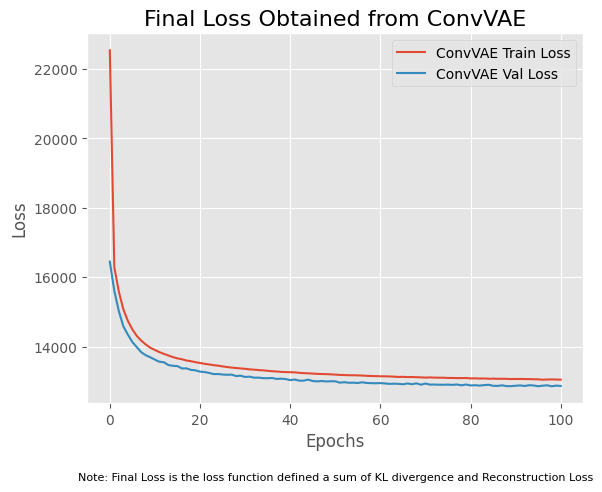

In [ ]:
plt.plot(train_epoch_losses, label="ConvVAE Train Loss")
plt.plot(val_epoch_losses, label="ConvVAE Val Loss")
plt.legend()
plt.title("Final Loss Obtained from ConvVAE", fontsize=16)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.annotate("Note: Final Loss is the loss function defined a sum of KL divergence and Reconstruction Loss",
                 xy=(0.5, 0), xytext=(0.5, -0.2),
                 xycoords='axes fraction', textcoords='axes fraction',
                 fontsize=8, ha='center', va='center')
plt.show()

## Plot of reconstruction loss

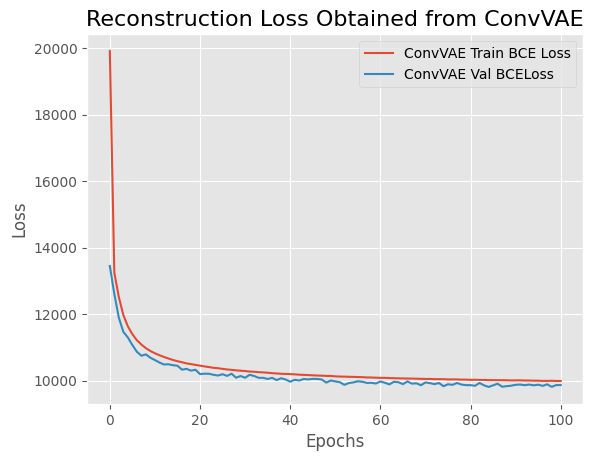

In [ ]:
plt.plot(train_epoch_bce_losses, label="ConvVAE Train BCE Loss")
plt.plot(val_epoch_bce_losses, label="ConvVAE Val BCELoss")
plt.legend()
plt.title("Reconstruction Loss Obtained from ConvVAE", fontsize=16)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

## A combined plot

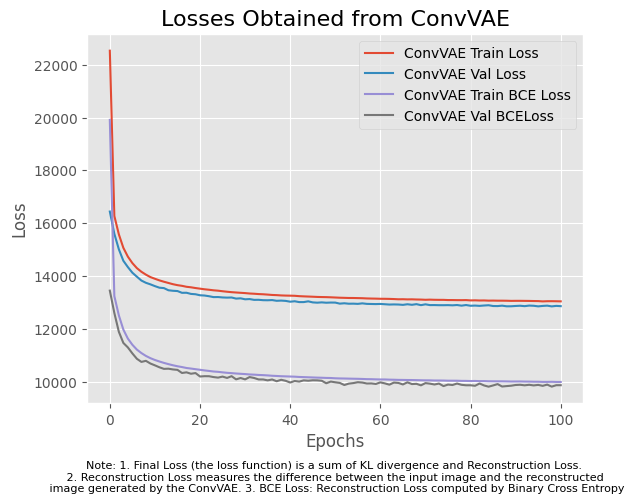

In [ ]:
plt.plot(train_epoch_losses, label="ConvVAE Train Loss")
plt.plot(val_epoch_losses, label="ConvVAE Val Loss")
plt.plot(train_epoch_bce_losses, label="ConvVAE Train BCE Loss")
plt.plot(val_epoch_bce_losses, label="ConvVAE Val BCELoss")
plt.legend()
plt.title("Losses Obtained from ConvVAE", fontsize=16)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.annotate('Note: 1. Final Loss (the loss function) is a sum of KL divergence and Reconstruction Loss. \n 2. Reconstruction Loss measures the difference between the input image and the reconstructed \n image generated by the ConvVAE. 3. BCE Loss: Reconstruction Loss computed by Binary Cross Entropy',
                 xy=(0.5, 0), xytext=(0.5, -0.2),
                 xycoords='axes fraction', textcoords='axes fraction',
                 fontsize=8, ha='center', va='center')

plt.show()